In [1]:
import pandas as pd
import multiprocessing as mp 
import matplotlib.pyplot as plt
import dask.dataframe as dd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
# df_2022 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2022.pkl')
# df_2023 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2023.pkl')

# single year
df_2022 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2022.pkl')

In [3]:
# Merger the dataframes
# ridership_data_all_years = pd.concat([df_2022, df_2023], axis=0)

In [4]:
#single year
ridership_df = df_2022.copy()

# multi year 
# ridership_df = ridership_data_all_years.copy()


In [5]:
ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514162 entries, 0 to 22514161
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transit_timestamp    datetime64[ns]
 1   transit_mode         object        
 2   station_complex_id   object        
 3   station_complex      object        
 4   borough              object        
 5   payment_method       object        
 6   fare_class_category  object        
 7   ridership            object        
 8   transfers            object        
 9   latitude             float64       
 10  longitude            float64       
 11  Georeference         object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 2.0+ GB


In [6]:
display(ridership_df.head())

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.99432,POINT (-73.99432 40.646294)
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.98426,POINT (-73.98426 40.74307)
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.92878,POINT (-73.92878 40.75204)
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.86263,POINT (-73.86263 40.883896)
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.91844,POINT (-73.91844 40.83377)


In [7]:
weather_df = pd.read_csv('data/Cleaned_data/weather_data_ny_cleaned.csv')
print(weather_df.head())
weather_df.info()

         DATE                         NAME  TMAX  TMIN  TAVG  PRCP  AWND  SNOW
0  2022-01-01  NY CITY CENTRAL PARK, NY US  56.0  50.0  53.0  0.79  3.13   0.0
1  2022-01-02  NY CITY CENTRAL PARK, NY US  59.0  37.0  48.0  0.04  5.82   0.0
2  2022-01-03  NY CITY CENTRAL PARK, NY US  37.0  22.0  29.5  0.00  9.84   0.0
3  2022-01-04  NY CITY CENTRAL PARK, NY US  34.0  19.0  26.5  0.00  6.04   0.0
4  2022-01-05  NY CITY CENTRAL PARK, NY US  47.0  31.0  39.0  0.23  5.59   0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1020 non-null   object 
 1   NAME    1020 non-null   object 
 2   TMAX    1020 non-null   float64
 3   TMIN    1020 non-null   float64
 4   TAVG    1020 non-null   float64
 5   PRCP    1020 non-null   float64
 6   AWND    1015 non-null   float64
 7   SNOW    1020 non-null   float64
dtypes: float64(6), object(2)
memory usage: 63.9+ 

In [8]:
ridership_df['transit_timestamp'] = pd.to_datetime(ridership_df['transit_timestamp'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

In [9]:
ridership_df.isnull().sum()

transit_timestamp      0
transit_mode           0
station_complex_id     0
station_complex        0
borough                0
payment_method         0
fare_class_category    0
ridership              0
transfers              0
latitude               0
longitude              0
Georeference           0
dtype: int64

In [10]:
weather_df.isnull().sum()

DATE    0
NAME    0
TMAX    0
TMIN    0
TAVG    0
PRCP    0
AWND    5
SNOW    0
dtype: int64

In [11]:
# display the null data in weather_df
weather_df[weather_df.isnull().any(axis=1)]

# update nan with avg value
weather_df['AWND'] = weather_df['AWND'].fillna(weather_df['AWND'].mean())


In [12]:
weather_df.isnull().sum()

DATE    0
NAME    0
TMAX    0
TMIN    0
TAVG    0
PRCP    0
AWND    0
SNOW    0
dtype: int64

In [13]:
ridership_df['hour'] = ridership_df['transit_timestamp'].dt.hour
ridership_df['day'] = ridership_df['transit_timestamp'].dt.date
ridership_df['weekday'] = ridership_df['transit_timestamp'].dt.weekday  # Monday=0, Sunday=6
ridership_df['month'] = ridership_df['transit_timestamp'].dt.month


In [14]:
ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514162 entries, 0 to 22514161
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transit_timestamp    datetime64[ns]
 1   transit_mode         object        
 2   station_complex_id   object        
 3   station_complex      object        
 4   borough              object        
 5   payment_method       object        
 6   fare_class_category  object        
 7   ridership            object        
 8   transfers            object        
 9   latitude             float64       
 10  longitude            float64       
 11  Georeference         object        
 12  hour                 int32         
 13  day                  object        
 14  weekday              int32         
 15  month                int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(10)
memory usage: 2.4+ GB


In [15]:
# convert day to datetime
ridership_df['day'] = pd.to_datetime(ridership_df['day'])

In [16]:
display(ridership_df.head())

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour,day,weekday,month
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.99432,POINT (-73.99432 40.646294),22,2022-02-17,3,2
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.98426,POINT (-73.98426 40.74307),23,2022-03-10,3,3
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.92878,POINT (-73.92878 40.75204),21,2022-10-05,2,10
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.86263,POINT (-73.86263 40.883896),22,2022-10-05,2,10
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.91844,POINT (-73.91844 40.83377),10,2022-10-05,2,10


In [17]:
# pd show all columns
pd.set_option('display.max_columns', None)

In [18]:
ridership_df = ridership_df.merge(weather_df, left_on='day', right_on='DATE', how='left')
display(ridership_df.head())

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour,day,weekday,month,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.99432,POINT (-73.99432 40.646294),22,2022-02-17,3,2,2022-02-17,"NY CITY CENTRAL PARK, NY US",68.0,49.0,58.5,0.31,7.38,0.0
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.98426,POINT (-73.98426 40.74307),23,2022-03-10,3,3,2022-03-10,"NY CITY CENTRAL PARK, NY US",51.0,33.0,42.0,0.00,1.79,0.0
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.92878,POINT (-73.92878 40.75204),21,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.86263,POINT (-73.86263 40.883896),22,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.91844,POINT (-73.91844 40.83377),10,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0


In [19]:
import holidays
us_holidays = holidays.US()
ridership_df['is_holiday'] = ridership_df['day'].apply(lambda x: 1 if x in us_holidays else 0)

In [20]:
display(ridership_df.head())

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour,day,weekday,month,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW,is_holiday
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.99432,POINT (-73.99432 40.646294),22,2022-02-17,3,2,2022-02-17,"NY CITY CENTRAL PARK, NY US",68.0,49.0,58.5,0.31,7.38,0.0,0
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.98426,POINT (-73.98426 40.74307),23,2022-03-10,3,3,2022-03-10,"NY CITY CENTRAL PARK, NY US",51.0,33.0,42.0,0.00,1.79,0.0,0
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.92878,POINT (-73.92878 40.75204),21,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.86263,POINT (-73.86263 40.883896),22,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.91844,POINT (-73.91844 40.83377),10,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0


In [21]:
# load and clean events 
events_df = pd.read_csv('data/Cleaned_data/events_mlb-cleaned.csv')
display(events_df.head())
events_df.info()


,event_name,start_date_time,end_date_time,event_type,event_borough,event_location,gps
0,New York Mets vs Arizona Diamondbacks,2022-04-15 13:10:00,2022-04-15 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
1,New York Mets vs Arizona Diamondbacks,2022-04-16 13:10:00,2022-04-16 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
2,New York Mets vs Arizona Diamondbacks,2022-04-17 13:40:00,2022-04-17 16:44:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
3,New York Mets vs San Francisco Giants,2022-04-18 19:10:00,2022-04-18 22:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
4,New York Mets vs San Francisco Giants,2022-04-19 15:10:00,2022-04-19 18:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   event_name       342 non-null    object
 1   start_date_time  342 non-null    object
 2   end_date_time    342 non-null    object
 3   event_type       342 non-null    object
 4   event_borough    342 non-null    object
 5   event_location   342 non-null    object
 6   gps              342 non-null    object
dtypes: object(7)
memory usage: 18.8+ KB


In [22]:
# convert start and edn time to datemtime 
events_df['start_date_time'] = pd.to_datetime(events_df['start_date_time'], errors='coerce')
events_df['end_date_time'] = pd.to_datetime(events_df['end_date_time'], errors='coerce')

events_df.info()
display(events_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_name       342 non-null    object        
 1   start_date_time  342 non-null    datetime64[ns]
 2   end_date_time    342 non-null    datetime64[ns]
 3   event_type       342 non-null    object        
 4   event_borough    342 non-null    object        
 5   event_location   342 non-null    object        
 6   gps              342 non-null    object        
dtypes: datetime64[ns](2), object(5)
memory usage: 18.8+ KB


,event_name,start_date_time,end_date_time,event_type,event_borough,event_location,gps
0,New York Mets vs Arizona Diamondbacks,2022-04-15 13:10:00,2022-04-15 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
1,New York Mets vs Arizona Diamondbacks,2022-04-16 13:10:00,2022-04-16 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
2,New York Mets vs Arizona Diamondbacks,2022-04-17 13:40:00,2022-04-17 16:44:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
3,New York Mets vs San Francisco Giants,2022-04-18 19:10:00,2022-04-18 22:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"
4,New York Mets vs San Francisco Giants,2022-04-19 15:10:00,2022-04-19 18:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)"


In [23]:
# Extract date and hour from event start and end times
events_df['event_date'] = events_df['start_date_time'].dt.date
events_df['event_start_hour'] = events_df['start_date_time'].dt.hour
events_df['event_end_hour'] = events_df['end_date_time'].dt.hour

display(events_df.head())


,event_name,start_date_time,end_date_time,event_type,event_borough,event_location,gps,event_date,event_start_hour,event_end_hour
0,New York Mets vs Arizona Diamondbacks,2022-04-15 13:10:00,2022-04-15 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-15,13,16
1,New York Mets vs Arizona Diamondbacks,2022-04-16 13:10:00,2022-04-16 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-16,13,16
2,New York Mets vs Arizona Diamondbacks,2022-04-17 13:40:00,2022-04-17 16:44:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-17,13,16
3,New York Mets vs San Francisco Giants,2022-04-18 19:10:00,2022-04-18 22:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-18,19,22
4,New York Mets vs San Francisco Giants,2022-04-19 15:10:00,2022-04-19 18:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-19,15,18


In [24]:
# manual lookup for now, downloaded mta subawasyu stations and complexes csv
event_location_to_station = {
    'Citi Field': 448,
    'Yankee Stadium': 604,
}

In [25]:
events_df['station_complex_id'] = events_df['event_location'].map(event_location_to_station)

In [26]:
events_df['event_date'] = pd.to_datetime(events_df['event_date'], errors='coerce')

In [27]:
events_df.info()
display(events_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   event_name          342 non-null    object        
 1   start_date_time     342 non-null    datetime64[ns]
 2   end_date_time       342 non-null    datetime64[ns]
 3   event_type          342 non-null    object        
 4   event_borough       342 non-null    object        
 5   event_location      342 non-null    object        
 6   gps                 342 non-null    object        
 7   event_date          342 non-null    datetime64[ns]
 8   event_start_hour    342 non-null    int32         
 9   event_end_hour      342 non-null    int32         
 10  station_complex_id  342 non-null    int64         
dtypes: datetime64[ns](3), int32(2), int64(1), object(5)
memory usage: 26.8+ KB


,event_name,start_date_time,end_date_time,event_type,event_borough,event_location,gps,event_date,event_start_hour,event_end_hour,station_complex_id
0,New York Mets vs Arizona Diamondbacks,2022-04-15 13:10:00,2022-04-15 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-15,13,16,448
1,New York Mets vs Arizona Diamondbacks,2022-04-16 13:10:00,2022-04-16 16:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-16,13,16,448
2,New York Mets vs Arizona Diamondbacks,2022-04-17 13:40:00,2022-04-17 16:44:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-17,13,16,448
3,New York Mets vs San Francisco Giants,2022-04-18 19:10:00,2022-04-18 22:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-18,19,22,448
4,New York Mets vs San Francisco Giants,2022-04-19 15:10:00,2022-04-19 18:14:00,Sport - MLB,Queens,Citi Field,"(40.757256, -73.846237)",2022-04-19,15,18,448


In [28]:
ridership_df.info()
display(ridership_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514162 entries, 0 to 22514161
Data columns (total 25 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transit_timestamp    datetime64[ns]
 1   transit_mode         object        
 2   station_complex_id   object        
 3   station_complex      object        
 4   borough              object        
 5   payment_method       object        
 6   fare_class_category  object        
 7   ridership            object        
 8   transfers            object        
 9   latitude             float64       
 10  longitude            float64       
 11  Georeference         object        
 12  hour                 int32         
 13  day                  datetime64[ns]
 14  weekday              int32         
 15  month                int32         
 16  DATE                 datetime64[ns]
 17  NAME                 object        
 18  TMAX                 float64       
 19  TMIN               

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour,day,weekday,month,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW,is_holiday
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.99432,POINT (-73.99432 40.646294),22,2022-02-17,3,2,2022-02-17,"NY CITY CENTRAL PARK, NY US",68.0,49.0,58.5,0.31,7.38,0.0,0
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.98426,POINT (-73.98426 40.74307),23,2022-03-10,3,3,2022-03-10,"NY CITY CENTRAL PARK, NY US",51.0,33.0,42.0,0.00,1.79,0.0,0
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.92878,POINT (-73.92878 40.75204),21,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.86263,POINT (-73.86263 40.883896),22,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.91844,POINT (-73.91844 40.83377),10,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0


In [55]:
# check is_holiday = 1
ridership_df[ridership_df['is_holiday'] == 1]

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour,day,weekday,month,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW,is_holiday,is_event
132,2022-10-10 14:00:00,subway,80,"121 St (J,Z)",Queens,omny,OMNY - Other,3,0,40.700493,-73.828290,POINT (-73.82829 40.700493),14,2022-10-10,0,10,2022-10-10,"NY CITY CENTRAL PARK, NY US",67.0,52.0,59.5,0.0,3.36,0.0,1,0
133,2022-10-10 22:00:00,subway,81,111 St (J),Queens,omny,OMNY - Full Fare,1,0,40.697420,-73.836340,POINT (-73.83634 40.69742),22,2022-10-10,0,10,2022-10-10,"NY CITY CENTRAL PARK, NY US",67.0,52.0,59.5,0.0,3.36,0.0,1,0
134,2022-10-10 22:00:00,subway,455,69 St (7),Queens,omny,OMNY - Full Fare,13,1,40.746326,-73.896400,POINT (-73.8964 40.746326),22,2022-10-10,0,10,2022-10-10,"NY CITY CENTRAL PARK, NY US",67.0,52.0,59.5,0.0,3.36,0.0,1,0
135,2022-06-20 17:00:00,subway,405,23 St (6),Manhattan,omny,OMNY - Full Fare,353,12,40.739864,-73.986600,POINT (-73.9866 40.739864),17,2022-06-20,0,6,2022-06-20,"NY CITY CENTRAL PARK, NY US",78.0,57.0,67.5,0.0,3.58,0.0,1,0
136,2022-06-20 05:00:00,subway,378,Woodlawn (4),Bronx,omny,OMNY - Full Fare,43,7,40.886036,-73.878750,POINT (-73.87875 40.886036),5,2022-06-20,0,6,2022-06-20,"NY CITY CENTRAL PARK, NY US",78.0,57.0,67.5,0.0,3.58,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22431401,2022-12-25 18:00:00,subway,91,Alabama Av (J),Brooklyn,metrocard,Metrocard - Unlimited 30-Day,1,0,40.676990,-73.898650,POINT (-73.89865 40.67699),18,2022-12-25,6,12,2022-12-25,"NY CITY CENTRAL PARK, NY US",28.0,14.0,21.0,0.0,8.50,0.0,1,0
22431416,2022-12-25 12:00:00,subway,97,"Myrtle Av (M,J,Z)",Brooklyn,metrocard,Metrocard - Unlimited 30-Day,10,0,40.697210,-73.935650,POINT (-73.93565 40.69721),12,2022-12-25,6,12,2022-12-25,"NY CITY CENTRAL PARK, NY US",28.0,14.0,21.0,0.0,8.50,0.0,1,0
22431423,2022-12-25 03:00:00,subway,90,"Van Siclen Av (J,Z)",Brooklyn,metrocard,Metrocard - Unlimited 30-Day,1,0,40.678024,-73.891685,POINT (-73.891685 40.678024),3,2022-12-25,6,12,2022-12-25,"NY CITY CENTRAL PARK, NY US",28.0,14.0,21.0,0.0,8.50,0.0,1,0
22431440,2022-12-25 17:00:00,subway,98,"Flushing Av (M,J)",Brooklyn,metrocard,Metrocard - Seniors & Disability,1,0,40.700260,-73.941124,POINT (-73.941124 40.70026),17,2022-12-25,6,12,2022-12-25,"NY CITY CENTRAL PARK, NY US",28.0,14.0,21.0,0.0,8.50,0.0,1,0


In [30]:
# convert all station_complex_id to int drop non numeric
ridership_df['station_complex_id'] = pd.to_numeric(ridership_df['station_complex_id'], errors='coerce')
ridership_df = ridership_df.dropna(subset=['station_complex_id'])
ridership_df['station_complex_id'] = ridership_df['station_complex_id'].astype(int)

ridership_df.info()
display(ridership_df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 22435756 entries, 0 to 22514161
Data columns (total 25 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transit_timestamp    datetime64[ns]
 1   transit_mode         object        
 2   station_complex_id   int32         
 3   station_complex      object        
 4   borough              object        
 5   payment_method       object        
 6   fare_class_category  object        
 7   ridership            object        
 8   transfers            object        
 9   latitude             float64       
 10  longitude            float64       
 11  Georeference         object        
 12  hour                 int32         
 13  day                  datetime64[ns]
 14  weekday              int32         
 15  month                int32         
 16  DATE                 datetime64[ns]
 17  NAME                 object        
 18  TMAX                 float64       
 19  TMIN                 flo

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour,day,weekday,month,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW,is_holiday
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.99432,POINT (-73.99432 40.646294),22,2022-02-17,3,2,2022-02-17,"NY CITY CENTRAL PARK, NY US",68.0,49.0,58.5,0.31,7.38,0.0,0
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.98426,POINT (-73.98426 40.74307),23,2022-03-10,3,3,2022-03-10,"NY CITY CENTRAL PARK, NY US",51.0,33.0,42.0,0.00,1.79,0.0,0
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.92878,POINT (-73.92878 40.75204),21,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.86263,POINT (-73.86263 40.883896),22,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.91844,POINT (-73.91844 40.83377),10,2022-10-05,2,10,2022-10-05,"NY CITY CENTRAL PARK, NY US",59.0,54.0,56.5,0.37,5.37,0.0,0


In [31]:
# just checking stations numbers do exist
# ridership_df[ridership_df['station_complex_id'] == 448].head()
# ridership_df[ridership_df['station_complex_id'] == 604].head()

In [32]:
ridership_df['is_event'] = 0



In [4]:
stations_with_events = events_df['station_complex_id'].unique()
print(f"Stations with events: {stations_with_events}")


NameError: name 'events_df' is not defined

In [34]:
# Filter ridership data for stations with events
ridership_events = ridership_df[ridership_df['station_complex_id'].isin(stations_with_events)].copy()


In [35]:
for station_id in stations_with_events:
    print(f"Processing station {station_id}")

    ridership_station = ridership_events[ridership_events['station_complex_id'] == station_id]

    events_station = events_df[events_df['station_complex_id'] == station_id]
    
    if ridership_station.empty or events_station.empty:
        continue
    
    event_starts = events_station['start_date_time'].values
    event_ends = events_station['end_date_time'].values
    
    ridership_times = ridership_station['transit_timestamp'].values
    
    is_event = np.zeros(len(ridership_station), dtype=bool)

    for start_time, end_time in zip(event_starts, event_ends):
        is_event |= (ridership_times >= start_time) & (ridership_times <= end_time)
    
    ridership_events.loc[ridership_events['station_complex_id'] == station_id, 'is_event'] = is_event.astype(int)

Processing station 448
Processing station 604


In [36]:

ridership_df['is_event'] = 0
is_event_mapping = ridership_events.set_index(ridership_events.index)['is_event']
ridership_df.loc[is_event_mapping.index, 'is_event'] = is_event_mapping.values


In [37]:
num_events_detected = ridership_df['is_event'].sum()
print(f"Number of ridership records during events: {num_events_detected}")


Number of ridership records during events: 3753


In [38]:
event_records_sample = ridership_df[ridership_df['is_event'] == 1].head()
print(event_records_sample[['transit_timestamp', 'station_complex_id', 'is_event']])


          transit_timestamp  station_complex_id  is_event
1790273 2022-09-28 22:00:00                 448         1
1791922 2022-09-28 20:00:00                 448         1
1792220 2022-09-28 21:00:00                 448         1
1793721 2022-09-28 20:00:00                 448         1
1794155 2022-09-28 20:00:00                 448         1


In [39]:
ridership_df['hour'] = ridership_df['transit_timestamp'].dt.hour
ridership_df['weekday'] = ridership_df['transit_timestamp'].dt.weekday
ridership_df['month'] = ridership_df['transit_timestamp'].dt.month


In [40]:
features = [
    'hour', 'weekday', 'month', 'is_holiday', 'is_event', 'station_complex_id'
]


X = ridership_df[features]
y = pd.to_numeric(ridership_df['ridership'], errors='coerce')

In [41]:
X.fillna(method='ffill', inplace=True)
y.fillna(method='ffill', inplace=True)

C:\Users\one1c\AppData\Local\Temp\ipykernel_29684\3198342668.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)
C:\Users\one1c\AppData\Local\Temp\ipykernel_29684\3198342668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(method='ffill', inplace=True)
C:\Users\one1c\AppData\Local\Temp\ipykernel_29684\3198342668.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y.fillna(method='ffill', inplace=True)


In [42]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X)


In [43]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [44]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs= 24)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=24, random_state=42)

In [45]:
y_pred_rf = rf_model.predict(X_test)

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R^2 Score: {r2_rf}")


Random Forest Performance:
Mean Absolute Error (MAE): 30.11671686256075
Mean Squared Error (MSE): 4244.0469740534045
R^2 Score: 0.3349282938945207


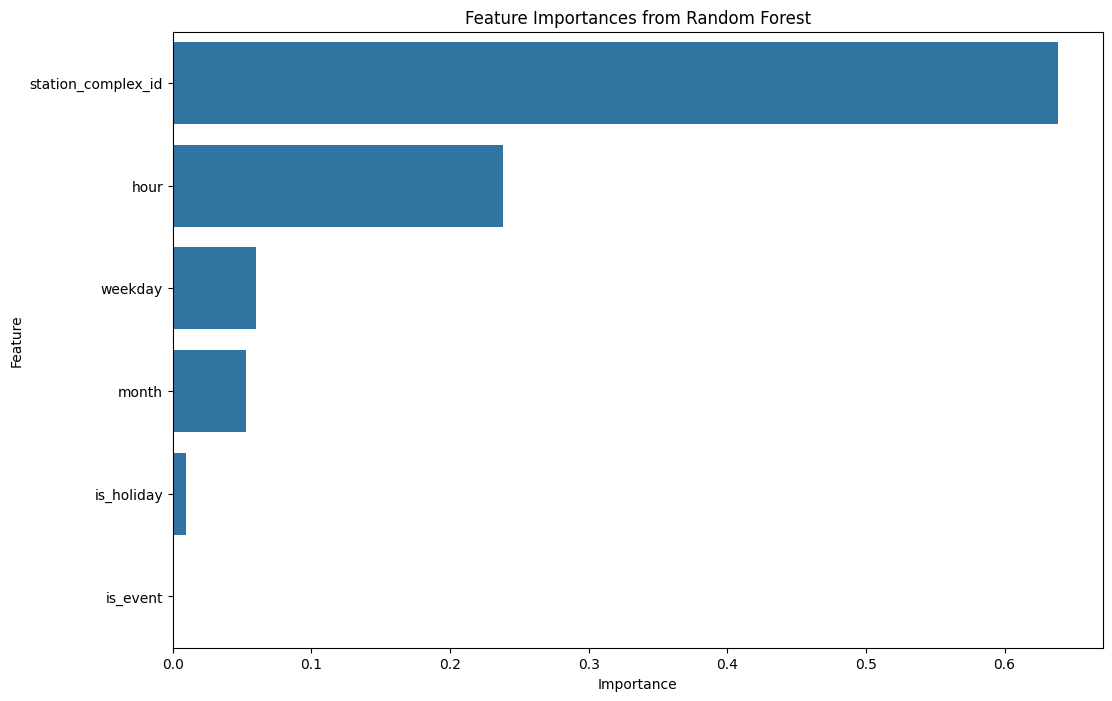

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# For Random Forest
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()


In [48]:
from sklearn.model_selection import GridSearchCV

from joblib import parallel_backend


param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [ 1, 5],
    'min_samples_split': [2, 4]
}


grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=24, 
    scoring='neg_mean_absolute_error',
    verbose=3
)


with parallel_backend('threading'):
    grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)


best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
print(f"Best Random Forest MAE: {mae_best_rf}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 3/3] END max_depth=5, min_samples_split=2, n_estimators=20;, score=nan total time=   3.7s
[CV 3/3] END max_depth=1, min_samples_split=4, n_estimators=10;, score=-40.353 total time= 2.1min
[CV 1/3] END max_depth=1, min_samples_split=2, n_estimators=10;, score=-40.344 total time= 2.2min
[CV 2/3] END max_depth=1, min_samples_split=4, n_estimators=10;, score=-40.354 total time= 2.2min
[CV 2/3] END max_depth=1, min_samples_split=2, n_estimators=10;, score=-40.354 total time= 2.3min
[CV 1/3] END max_depth=1, min_samples_split=4, n_estimators=10;, score=-40.344 total time= 2.3min
[CV 3/3] END max_depth=1, min_samples_split=2, n_estimators=10;, score=-40.353 total time= 2.3min
[CV 3/3] END max_depth=1, min_samples_split=4, n_estimators=20;, score=-40.352 total time= 3.5min
[CV 2/3] END max_depth=1, min_samples_split=4, n_estimators=20;, score=-40.350 total time= 3.6min
[CV 1/3] END max_depth=1, min_samples_split=4, n_estimators=20

C:\Users\one1c\.conda\envs\capstone_1\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\one1c\.conda\envs\capstone_1\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\one1c\.conda\envs\capstone_1\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\one1c\.conda\envs\capstone_1\Lib\site-packages\sklearn\ensemble\_

Best Parameters: {'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 20}
Best Random Forest MAE: 36.457293434432124


In [49]:
# from sklearn.model_selection import cross_val_score

# cv_scores_rf = cross_val_score(
#     rf_model, X_scaled, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=24
# )

# print(f"Cross-validated MAE for Random Forest: {-cv_scores_rf.mean()}")


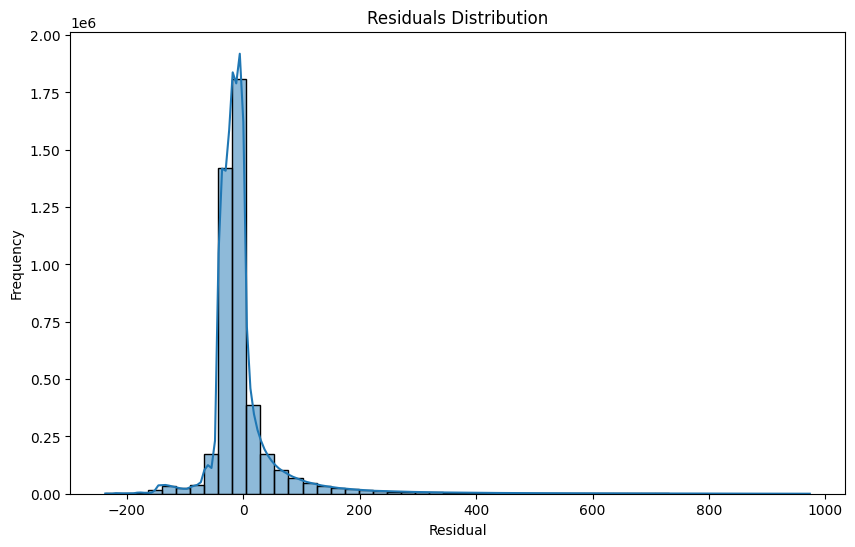

In [50]:
residuals = y_test - y_pred_best_rf

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


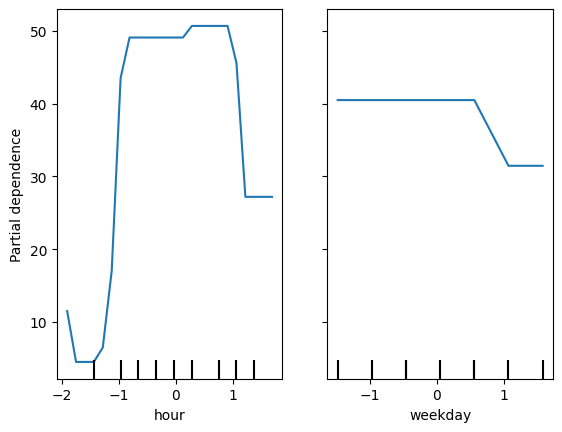

In [51]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = [0, 1]
PartialDependenceDisplay.from_estimator(
    best_rf_model, X_test, features_to_plot, feature_names=features
)
plt.show()


In [52]:
import joblib

# Save the model
joblib.dump(best_rf_model, 'ridership_prediction_model.pkl')

# To load the model later
# model = joblib.load('ridership_prediction_model.pkl')


['ridership_prediction_model.pkl']

In [53]:
from sklearn.preprocessing import StandardScaler
import joblib

# Assuming you have your feature matrix X from training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [54]:
# Load the model and scaler
import joblib
model = joblib.load('ridership_prediction_model.pkl')
scaler = joblib.load('scaler.pkl')  # Ensure the scaler is loaded

# Create new data
new_data = pd.DataFrame({
    'station_complex_id': [604, 604,604,604],
    'hour': [9, 12, 17, 18],
    'weekday': [1, 1, 0, 0],
    'month': [6, 6, 6, 6],
    'is_holiday': [0, 0, 0, 0]
#     'is_event': [0, 1, 1, 0],
#     'TMAX': [75.0, 78.0, 80.0, 77.0],
#     'TMIN': [60.0, 65.0, 68.0, 66.0],
#     'TAVG': [67.5, 71.5, 74.0, 71.5],
#     'PRCP': [0.0, 0.0, 0.0, 0.0],
#     'SNOW': [0.0, 0.0, 0.0, 0.0],
})

# Preprocess new data
new_data = pd.get_dummies(new_data, columns=['weekday'], drop_first=True)

# Ensure all expected columns are present
expected_columns = X.columns  # From training
missing_cols = set(expected_columns) - set(new_data.columns)
for col in missing_cols:
    new_data[col] = 0

# Reorder columns
new_data = new_data[expected_columns]

# Scale the data
new_data_scaled = scaler.transform(new_data)

# Make predictions
predictions = model.predict(new_data_scaled)
predicted_ridership = predictions.round().astype(int)

# Add predictions to the DataFrame
new_data['predicted_ridership'] = predicted_ridership

# Display the results
print(new_data[['hour', 'is_event', 'predicted_ridership']])



   hour  is_event  predicted_ridership
0     9         0                   77
1    12         0                   77
2    17         0                   77
3    18         0                   77
